## 目的
言葉の相対位置を検出する相対位置エンコーディングの実装法についてまとめる

## Relative Positional Encoding の特徴
1. 単語（token）の“相対的な距離”を学習する

従来の 絶対位置埋め込み (absolute PE) は
「1番目の単語」「2番目の単語」…のように 固定された順序 を渡しますが、相対位置埋め込み は

「この単語の左に2個目にある単語」

「右隣の単語」

のように 距離関係 をモデルに教えます。
順番そのものではなく “間隔” を理解する

2. 文の長さが変わっても性能が安定

絶対PEは

→ 長さが変わると位置がズレる

相対PEは

→ 距離で判断するので、文章長変化に強い

表形式データ、音声、コード理解、長文タスクに有利。


## 実装例

1. 相対位置バイアスを持つ Multi-Head Attention を実装（T5風の簡易版）
2. 同じ入力で「相対PEあり」と「なし」の Attention 重みを比較（heatmap）
3. 学習可能な相対バイアスの値を可視化（relative distance vs heads のプロット）
4. 出力の違い（簡単な差分・cos類似）を表示

In [ ]:
# 必要ライブラリ：torch, matplotlib, seaborn, numpy, sklearn(optional)
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

バケット距離の動作を確認する。

文章の長さをベースに位置に対応するバケット距離を定義するテンソルを定義する。

定義するのは近いと認める相対距離

In [ ]:
seq_len = 128
# 順番を示す配列
idxs = torch.arange(seq_len, device=device)
# 各位置に相当する相対距離を行列化
rel = idxs[None, :] - idxs[:, None]
print(rel.shape)
print(f"相対距離行列{rel}")

max_rel_pos = 8
# 相対距離（i − j）を、固定範囲 [-max_rel_pos, max_rel_pos] に収めて、0〜(2*max_rel_pos) のインデックスに変換
rel_clipped = rel.clamp(-max_rel_pos, max_rel_pos) + max_rel_pos

print(rel_clipped)

torch.Size([128, 128])
相対距離行列tensor([[   0,    1,    2,  ...,  125,  126,  127],
        [  -1,    0,    1,  ...,  124,  125,  126],
        [  -2,   -1,    0,  ...,  123,  124,  125],
        ...,
        [-125, -124, -123,  ...,    0,    1,    2],
        [-126, -125, -124,  ...,   -1,    0,    1],
        [-127, -126, -125,  ...,   -2,   -1,    0]])
tensor([[ 8,  9, 10,  ..., 16, 16, 16],
        [ 7,  8,  9,  ..., 16, 16, 16],
        [ 6,  7,  8,  ..., 16, 16, 16],
        ...,
        [ 0,  0,  0,  ...,  8,  9, 10],
        [ 0,  0,  0,  ...,  7,  8,  9],
        [ 0,  0,  0,  ...,  6,  7,  8]])


In [ ]:
# 相対位置バイアスを持つMulti-Head Attention
class MultiHeadAttentionRel(nn.Module):
  def __init__(self, embed_dim, num_heads, max_rel_pos=8, dropout=0.0):
    super().__init__()
    assert embed_dim % num_heads == 0
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_dim = embed_dim // num_heads
    self.scale = math.sqrt(embed_dim // num_heads)

    # 結合層
    self.q_lin = nn.Linear(embed_dim, embed_dim)
    self.k_lin = nn.Linear(embed_dim, embed_dim)
    self.v_lin = nn.Linear(embed_dim, embed_dim)
    self.out_lin = nn.Linear(embed_dim, embed_dim)
    self.dropout = nn.Dropout(dropout)

    # 距離バケット計算用のパラメータ
    self.max_rel_pos = max_rel_pos
    self.relative_bias = nn.Parameter(torch.zeros(num_heads, 2 * max_rel_pos + 1))

  # 距離バケットを計算する
  def __relative_index(self, seq_len, device):
      # create matrix of relative indices clipped to [-max_rel_pos, max_rel_pos]
      idxs = torch.arange(seq_len, device=device)
      rel = idxs[None, :] - idxs[:, None]   # shape (seq_len, seq_len): i - j
      rel_clipped = rel.clamp(-self.max_rel_pos, self.max_rel_pos) + self.max_rel_pos
      # now in range [0, 2*max_rel_pos]
      return rel_clipped.long()  # (seq_len, seq_len)

  # 分散表現を分割
  def __split_head(self, x):
    batch, seq, _ = x.size()
    x = x.view(batch, seq, self.num_heads, self.head_dim)
    return x.permute(0, 2, 1, 3)  # (b, heads, seq, head_dim)

  # 分割分を結合
  def __combine_heads(self, x):
    # x: (b, heads, seq, head_dim)
    b, h, seq, hd = x.size()
    x = x.permute(0, 2, 1, 3).contiguous()  # (b, seq, heads, head_dim)
    return x.view(b, seq, h * hd)

  # 順伝播
  def forward(self, query, key, value, mask=None, use_relative=True):
    # inputs: (batch, seq, embed_dim
    batch, seq, _ = query.size()
    Q = self.__split_head(self.q_lin(query))  # (b, h, seq, hd)
    K = self.__split_head(self.k_lin(key))
    V = self.__split_head(self.v_lin(value))

    attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

    if use_relative:
      # get index matrix (seq, seq) -> gather bias per head
      rel_idx = self.__relative_index(seq, device=attn_scores.device)  # (seq, seq)
      # 位置に基づく距離バケット
      bias_per_head = self.relative_bias[:, rel_idx]  # broadcasting on first dim
      # bias_per_head shape: (heads, seq, seq)
      # expand to batch: (b, heads, seq, seq)
      bias_per_head = bias_per_head.unsqueeze(0).expand(batch, -1, -1, -1)
      attn_scores = attn_scores + bias_per_head

    if mask is not None:
        scores = scores.masked_fill(mask.unsqueeze(1), float('-inf'))  # mask shape broadcast

    attn = F.softmax(attn_scores, dim=-1)
    attn = self.dropout(attn)

    context = torch.matmul(attn, V)  # (b, h, seq, hd)
    out = self.__combine_heads(context)  # (b, seq, embed_dim)
    out = self.out_lin(out)
    return out, attn, attn_scores  # return scores (pre-softmax) and attn (post-softmax)



In [ ]:
# ヒートマップによる可視化
def plot_attention_maps(attn_no_rel, attn_rel, head=0, tokens=None, figsize=(10,4)):
  # attn shapes: (b, heads, seq, seq). We'll use batch 0.
  a0 = attn_no_rel[0, head].detach().cpu().numpy()
  a1 = attn_rel[0, head].detach().cpu().numpy()
  seq = a0.shape[0]
  if tokens is None:
      tokens = [str(i) for i in range(seq)]

  fig, axes = plt.subplots(1, 3, figsize=figsize)
  sns.heatmap(a0, ax=axes[0], cmap='Blues', xticklabels=tokens, yticklabels=tokens)
  axes[0].set_title("No RelativePE (head {})".format(head))
  sns.heatmap(a1, ax=axes[1], cmap='Blues', xticklabels=tokens, yticklabels=tokens)
  axes[1].set_title("With RelativePE (head {})".format(head))
  sns.heatmap(a1 - a0, ax=axes[2], cmap='RdBu', center=0, xticklabels=tokens, yticklabels=tokens)
  axes[2].set_title("Difference (with - without)")
  plt.tight_layout()
  plt.show()


In [ ]:
# 相対位置エンコーディングの重みを表示する
def plot_relative_bias_table(mha_rel):
  # relative_bias shape: (heads, 2*max_rel+1)
  bias = mha_rel.relative_bias.detach().cpu().numpy()
  heads, L = bias.shape
  xs = np.arange(-mha_rel.max_rel_pos, mha_rel.max_rel_pos + 1)
  plt.figure(figsize=(8,4))
  for h in range(heads):
      plt.plot(xs, bias[h], label=f"head{h}")
  plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
  plt.xlabel("relative position (i-j)")
  plt.ylabel("bias")
  plt.title("Learned relative positional bias per head")
  plt.legend()
  plt.show()

In [ ]:
# ------------------------
# デモ開始
# ------------------------
# create toy input (batch=1, seq_len=12, embed=32)
batch, seq_len, embed_dim = 1, 12, 32
# マルチヘッドは4
num_heads = 4
# 入力埋め込み表現はランダムに生成
x = torch.randn(batch, seq_len, embed_dim, device=device)

# 位置エンコーディングの相対位置maxは5と定義
mha = MultiHeadAttentionRel(embed_dim=embed_dim, num_heads=num_heads, max_rel_pos=5, dropout=0.0).to(device)

In [ ]:
# 文章にグループ情報を埋め込む
for i in range(seq_len):
  group = i // 4
  x[0, i] += group * 0.5

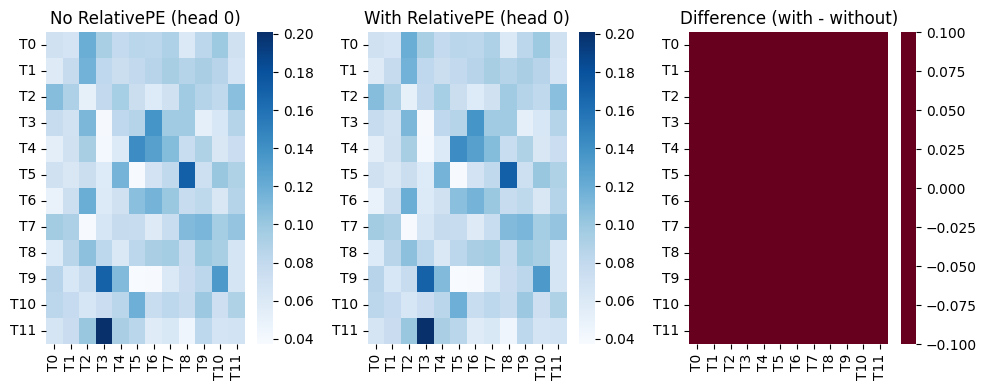

In [ ]:
# 相対位置エンコーディングを持たないMulti-Headで埋め込み表現取得
with torch.no_grad():
  out_no_rel, attn_no_rel, scores_no_rel = mha(x, x, x, use_relative=False)

# 相対位置エンコーディングを持つMulti-Headで埋め込み表現取得
with torch.no_grad():
  out_rel, attn_rel, scores_rel = mha(x, x, x, use_relative=True)

# 先頭ヘッドのアテンションを可視化
plot_attention_maps(attn_no_rel.cpu(), attn_rel.cpu(), head=0, tokens=[f"T{i}" for i in range(seq_len)])

## マルチヘッドの学習
このコードは、相対位置バイアス（relative positional bias）に学習を行い、Attentionが「近いトークンほど強く注意する」性質を獲得させるための訓練です。

✅ 何を学習しているか？

学習対象：mha.relative_bias（相対位置バイアス）

目的：Attentionが対角成分（＝隣接・近距離トークン）に大きくなるようにする

つまり、

近い位置のトークン同士を強く関連付ける
→ Relative Position Encoding が「距離感」を学習する

という訓練です。

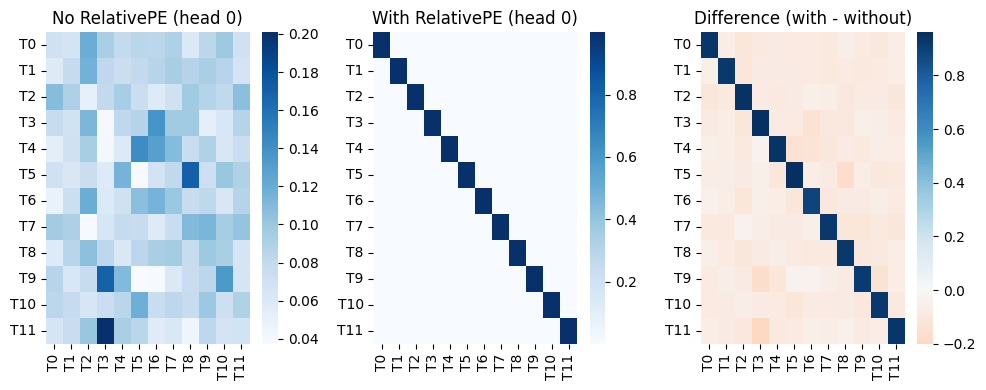

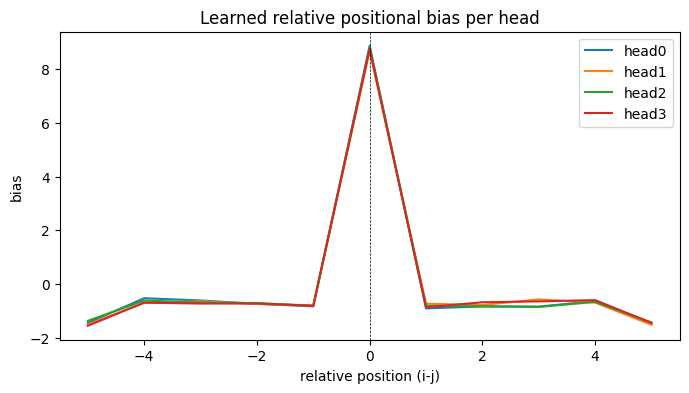

In [ ]:
# 学習してから埋め込み量の変化を確認する
opt = torch.optim.SGD([mha.relative_bias], lr=0.5)
mha.train()
for step in range(200):
  opt.zero_grad()
  # simple objective to encourage attention to prefer nearby tokens:
  out, attn, scores = mha(x, x, x, use_relative=True)
  # we want attention to concentrate on diagonal: maximize sum of diag elements
  diag = torch.stack([attn[0, h].diag().sum() for h in range(num_heads)]).sum()
  loss = -diag  # maximize diagonal
  loss.backward()
  opt.step()

mha.eval()
with torch.no_grad():
  _, attn_rel_trained, _ = mha(x, x, x, use_relative=True)

# show updated maps
plot_attention_maps(attn_no_rel.cpu(), attn_rel_trained.cpu(), head=0, tokens=[f"T{i}" for i in range(seq_len)])
plot_relative_bias_table(mha)

## 相対位置エンコーディングの効果測定
### 1) 相対PEなし vs 相対PEありの出力の類似度を比較
相対PEなし vs 相対PEありの出力の類似度を比較
sim_before = ...
print(f"Average cosine similarity ... (before training bias)")


相対PEなし (out_no_rel) と、相対PEあり (out_rel) の出力ベクトルのコサイン類似度を計算しています。

平均コサイン類似度が1に近い → ほぼ同じ

低い → 相対PEで位置情報が大きく影響した

__意味__

相対PEが、出力をどれだけ変えたかの指標です。

In [ ]:
# Compare outputs (cosine similarity between out_no_rel and out_rel)
vec_no = out_no_rel.view(-1, embed_dim).detach().cpu().numpy()
vec_rel = out_rel.view(-1, embed_dim).detach().cpu().numpy()
from sklearn.metrics.pairwise import cosine_similarity
sim_before = np.mean(np.diag(cosine_similarity(vec_no, vec_rel)))
print(f"Average cosine similarity between outputs (before training bias): {sim_before:.4f}")

# After training bias
vec_rel_tr = out_rel.detach().cpu().numpy()  # note out_rel was computed before bias training; recompute:
with torch.no_grad():
    out_rel_after, _, _ = mha(x, x, x, use_relative=True)
vec_rel_after = out_rel_after.view(-1, embed_dim).detach().cpu().numpy()
sim_after = np.mean(np.diag(cosine_similarity(vec_no, vec_rel_after)))
print(f"Average cosine similarity between (no_rel) and (with_rel) after training bias: {sim_after:.4f}")

Average cosine similarity between outputs (before training bias): 1.0000
Average cosine similarity between (no_rel) and (with_rel) after training bias: 0.5858


### 2) 相対PE パラメータを学習後の変化を確認
out_rel_after = ...
sim_after = ...
print(f"Average cosine similarity ... after training bias")


相対PEのバイアスを学習させ、再度コサイン類似度を算出

sim_after の変化を見ることで、

相対PEの学習により、どれだけ「位置情報の効果」が強まったか

がわかります。

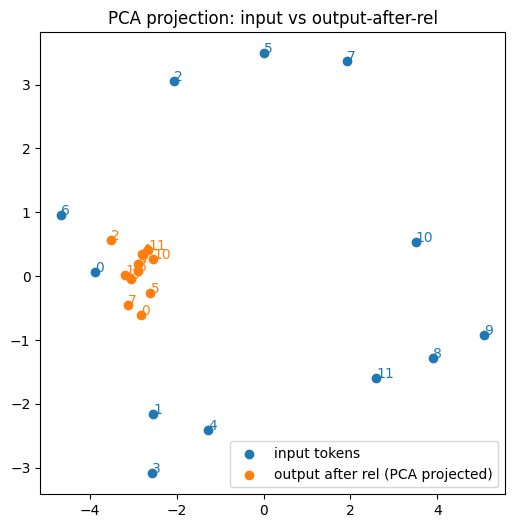

In [ ]:
# Optional: PCA plot of token embeddings before/after (input vs output after rel)
pca = PCA(n_components=2)
inp_2d = pca.fit_transform(x[0].cpu().numpy())
outrel_2d = pca.transform(out_rel_after[0].cpu().numpy())
plt.figure(figsize=(6,6))
plt.scatter(inp_2d[:,0], inp_2d[:,1], label="input tokens")
plt.scatter(outrel_2d[:,0], outrel_2d[:,1], label="output after rel (PCA projected)")
for i in range(seq_len):
    plt.text(inp_2d[i,0], inp_2d[i,1], f"{i}", color="C0")
    plt.text(outrel_2d[i,0], outrel_2d[i,1], f"{i}", color="C1")
plt.legend(); plt.title("PCA projection: input vs output-after-rel")
plt.show()
